<a href="https://colab.research.google.com/github/kaouther4habib/Deep-Autoencoder-based-Clustering-of-Histopathological-Images/blob/master/PFE_CONV_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up the env**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from keras.models import Sequential
!pip install umap-learn
!pip install umap-learn[plot]
!pip install hdbscan
!pip install seaborn
import pickle
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Reshape
import hdbscan
import seaborn as sns
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dense, Activation, Flatten, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 7.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ebfc721fbd2fae30203be7483097ce3b8a0498b75bb66bf07f13c8e9fe6bd90d
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=776381a3d86f0f60ac555274475b436f2a8550752819334aaefe9ae25b3f9592
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 1.4 MB/s 
     |████████████████████████████████| 76 kB 2.9 MB/s 
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342129 sha256=0cbd258879d0010d7f143dc2c7e04db2b63d5f881ea07460d0e537fa6ff5193b
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Umap Implementation

In [ ]:
import umap.umap_ as umap
import umap.plot

def learn_manifold(x_data, umap_min_dist=0.00, umap_metric='euclidean', umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    return umap.UMAP(
        random_state=0,
        metric=umap_metric,
        n_components=umap_dim,
        n_neighbors=umap_neighbors,
        min_dist=md).fit_transform(x_data)

# Loading data from drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# from fastai.datasets import datapath4file
# Change the working directory
%cd /content/drive/MyDrive/data/datahisto/


Mounted at /content/drive
/content/drive/MyDrive/data/datahisto


In [ ]:
ls

8863/  8867/  app.py             model_simp_ae.pb/  SIMPdbscan    umap
8864/  8913/  logs/              SIMPAE             SIMPhdbscan1
8865/  8914/  model_conv_ae.pb/  SIMPagglo          SIMPKMEANS


In [ ]:
%cd /content/drive/MyDrive/data/datahisto



/content/drive/MyDrive/data/datahisto


In [ ]:
from glob import glob

# PATH_OF_DATA= '/content/drive/MyDrive/datahis2/8863/0'
imagePatches = glob('/content/drive/MyDrive/data/datahisto/**/**/*.png', recursive=True)

In [ ]:
len(imagePatches)

19422

Displaying the images


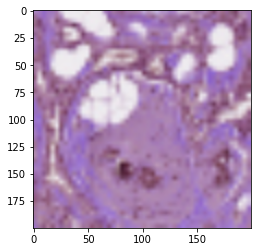

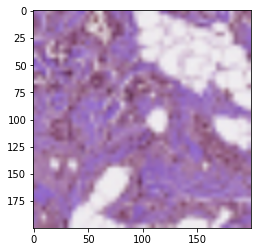

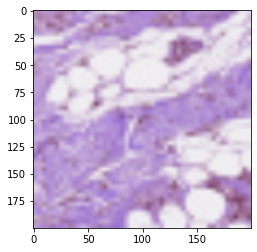

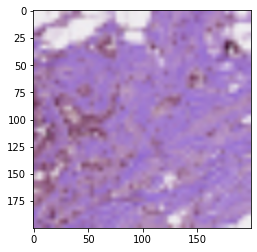

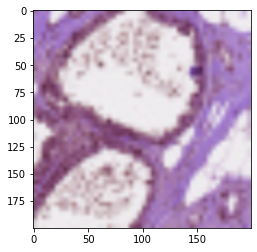

In [ ]:
import cv2
import matplotlib.pyplot as plt
for i in imagePatches[:5]:
     img=cv2.imread(i)
     img_1=cv2.resize(img,(200,200))
     plt.imshow(img_1,cmap='binary')
     plt.show()


# Preparing the data

In [ ]:
images=[]
labels=[]
for i in imagePatches[:19422]: #19422
     if i.endswith('.png'):
         label=i[-5]
         img=cv2.imread(i)
         img_1=cv2.resize(img,(96,96))
         images.append(img_1)
         labels.append(label)

In [ ]:
x=np.stack(images)




In [ ]:
from tensorflow.keras.utils import to_categorical
y=to_categorical(labels)



Convert images to gray scale

In [ ]:
X_train_grayscale = np.zeros(x.shape[:-1])
for i in range(x.shape[0]): 
  
    X_train_grayscale[i] = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY) 

In [ ]:
print(x.shape)
print(y.shape)

(19422, 96, 96, 3)
(19422, 2)


In [ ]:
true_label= y.ravel()
print(true_label.shape)

true_label2 = np.resize(true_label,3885)
print(true_label2.shape)

(38844,)
(3885,)


Split data to train and test

In [ ]:
 from sklearn.model_selection import train_test_split
 x_train,x_test,y_train,y_test=train_test_split(X_train_grayscale,y,random_state=0,test_size=0.2)


 x_train = x_train.astype('float32') /255.
 x_test = x_test.astype('float32') / 255.
 y_train = y_train.astype('float32')/255.
 y_test = y_test.astype('float32')/255.

 print(x_train.shape)
 print(x_test.shape)
 print(y_train.shape)
 print(y_test.shape)

(15537, 96, 96)
(3885, 96, 96)
(15537, 2)
(3885, 2)


# Building basic convolutional AE

In [ ]:
class ConvAE(Model):
  def __init__(self):
    super(ConvAE, self).__init__()
    self.encoder = tf.keras.Sequential([
    layers.Input(shape=(96,96,1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same')
  ])
    self.decoder = tf.keras.Sequential([
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'), 
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),
      layers.UpSampling2D((3, 3)),
      layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'), 

    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ConvAE()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [ ]:
# input_img = Input(shape=(96, 96, 1))  

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
# x = MaxPooling2D((3, 3), padding='same')(x) 
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
# x = MaxPooling2D((2, 2), padding='same')(x) 
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) 
# encoded = MaxPooling2D((2, 2), padding='same')(x) 

# # at this point the representation is (8, 8, 128) 

# x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded) 
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) 
# x = UpSampling2D((2, 2))(x) 
# x = UpSampling2D((3, 3))(x) 
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) 

# autoencoder = Model(input_img, decoded)
# # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')



Training the model

In [ ]:
autoencoder_train = autoencoder.fit(x_train, x_train,
                epochs=10,  
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
               )

Epoch 1/10
122/122 [==============================] - 601s 5s/step - loss: 0.0146 - val_loss: 0.0068
Epoch 2/10
122/122 [==============================] - 591s 5s/step - loss: 0.0058 - val_loss: 0.0052
Epoch 3/10
122/122 [==============================] - 586s 5s/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/10
122/122 [==============================] - 591s 5s/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/10
122/122 [==============================] - 590s 5s/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/10
122/122 [==============================] - 590s 5s/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/10
122/122 [==============================] - 590s 5s/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/10
122/122 [==============================] - 591s 5s/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/10
122/122 [==============================] - 588s 5s/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/10
122/122 [==============================] - 592s 5s/step - loss: 0.0036 - val_lo

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(x_test.shape)

print(encoded_imgs.shape)
print(decoded_imgs.shape)

Testing and diplaying the results

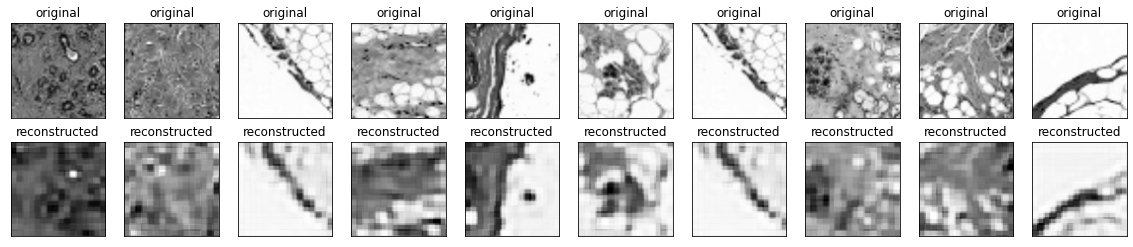

In [ ]:
n= 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(96,96))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# K-means clustering

In [ ]:
encoded_dimensions = 10
nsamples, nx, ny, nz = encoded_imgs.shape
X_encoded = encoded_imgs.reshape((nsamples,nx*ny*nz))
X_reduced = learn_manifold(X_encoded, umap_neighbors=30, umap_dim=int(encoded_dimensions/2))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Implementing the elbow method to determine the number of K


Text(0, 0.5, 'WCSS')

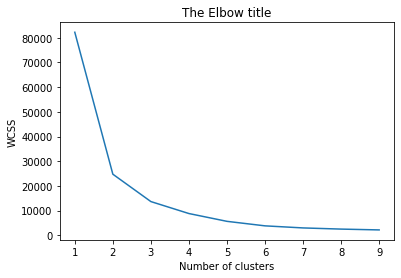

In [ ]:
from sklearn.cluster import KMeans

wcss=[]
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(X_reduced)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Implementing k-means with k=3

In [ ]:
k_encoded = KMeans(3).fit(X_reduced)
encoded_clustered = k_encoded.predict(X_reduced)


[0 1 2]


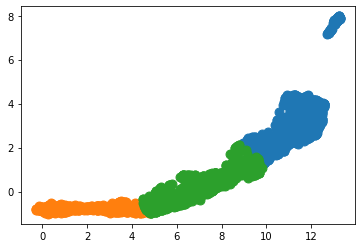

In [ ]:
u_labels = np.unique(encoded_clustered)
print(u_labels)
#plotting the results:
for i in u_labels:
   plt.scatter(X_reduced[encoded_clustered==i,0], X_reduced[encoded_clustered==i,1], s=80)

# Evaluation measures for K-means

 *Silhouette measure for kmeans*


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

score = silhouette_score(X_reduced, k_encoded.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.538


Visualising the silhouette score

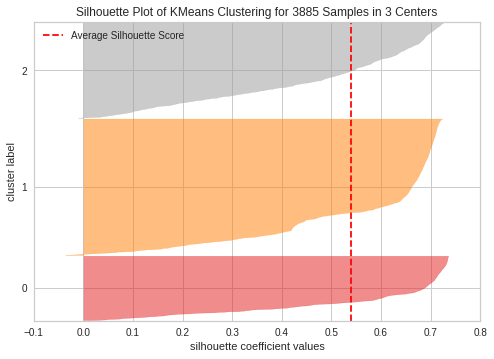

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

clf = KMeans(n_clusters=3)
vzr = SilhouetteVisualizer(clf)
vzr.fit(X_reduced)
vzr.poof()

*Davis Bouldin measure*

In [ ]:
from sklearn.metrics import davies_bouldin_score


db_index = davies_bouldin_score(X_reduced, k_encoded.labels_)
print(db_index)

0.5828824597912903


# Hierarchical Clustering

Implementing the algorithm

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_reduced)
print(cluster.labels_)

n_clusters_ = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)
print(n_clusters_)

[1 2 0 ... 1 1 2]
3


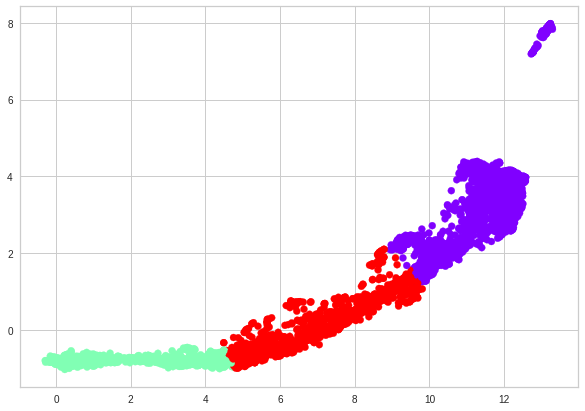

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=k_encoded.labels_, cmap='rainbow')

# DBSCAN Clusterig

Implementing the algorirthm

[0 0 0 ... 0 0 0]


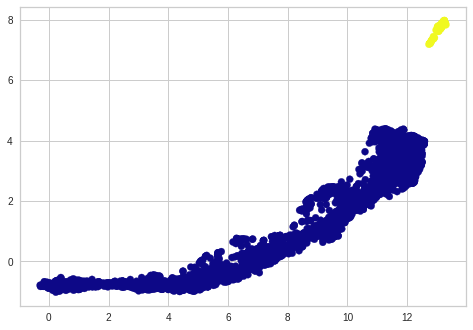

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

clustering = DBSCAN(eps=1, min_samples=3).fit(X_reduced)
#Storing the labels formed by the DBSCAN
labels = clustering.labels_
print(labels)

plt.scatter(X_reduced[:, 0], X_reduced[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.show() # showing the plot

# n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
# print(n_clusters_)

# HDBSCAN CLUSTERING

[HDBSCAN(min_cluster_size=50, prediction_data=True)]
2


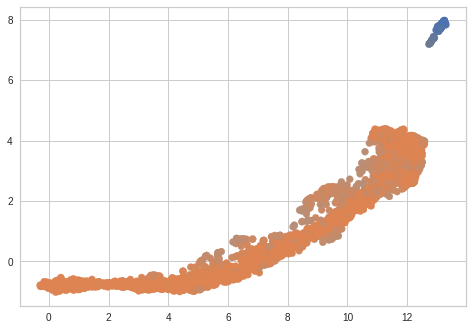

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,prediction_data=True).fit(X_reduced)
  
h_labels = np.unique(clusterer)
print(h_labels)

#Plotting the results
pal = sns.color_palette('deep', 9)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(X_reduced.T[0], X_reduced.T[1], c=colors);


n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print(n_clusters_)

# Mean shift clustering

Number of clusters is: 3


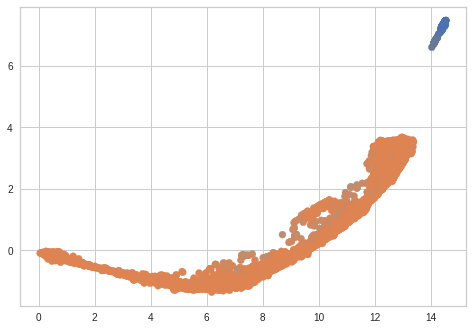

In [ ]:
from sklearn.cluster import MeanShift,estimate_bandwidth

bandwidth = estimate_bandwidth(X_reduced, quantile=0.2, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
model = ms.fit(X_reduced)
cluster_centers = ms.cluster_centers_


fig = plt.figure()
  

#Plotting the results
pal = sns.color_palette('deep', 10)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(X_reduced.T[0], X_reduced.T[1], c=colors);
n_clusters_ = len(set(k_encoded.labels_)) - (1 if -1 in k_encoded.labels_ else 0)

print('Number of clusters is: '+str(n_clusters_))

In [ ]:
## save model
filepath = "/content/drive/MyDrive/data/datahisto/model_conv_ae.pb"
tf.keras.models.save_model(
    autoencoder,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/datahisto/model_conv_ae.pb/assets
